In [1]:
import os
import pandas as pd
import numpy as np
import plotly.express as px
from pycaret.regression import *
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from openpyxl import load_workbook, Workbook
import src.paychex_ml.data_loader as dl
import src.paychex_ml.models as models

warnings.filterwarnings("ignore")

In [2]:
proyect_path = "C:/Users/bruno.gonzalez/DataspellProjects/Paychex_revenue_forecast"

In [3]:
# ------------------------------------------------------------------------------------- #
# This is where we change parameters to the model
# ------------------------------------------------------------------------------------- #
train_start_dt = '20140601'
train_end_dt = '20200501'
test_start_dt = '20200601'
test_end_dt = '20210501'
pred_start_dt = '20210601'
pred_end_dt = '20220101'
ml_criteria = 'MAE'
forecast_window = 8
forecast_type = '2+10'
# This is how strong you want the correlation to be in order to be included as a feature
correlation_threshold = 0.5
# This is how many features you want to keep in the final model
features_threshold = 10

In [4]:
# Set manually date if is necessary
model_run_date = datetime.today().strftime('%Y%m%d')
#model_run_date = '20220504'

In [5]:
items_dicctionary = {
    '11': ('Payroll blended products', True),
    '12': ('W-2 Revenue', False),
    '13': ('Delivery Revenue', False),
    '14': ('ASO Allocation', False),
    '15': ('Other Processing Revenue', False),
    '16': ('SurePayroll.', True),
    '17': ('Total international', False),
    '21': ('401K Fee Revenue', True),
    '22': ('401K Asset fee & BP Revenue', True),
    '23': ('HR Solutions (PEO)', False),
    '24': ('ASO Revenue - Oasis', False),
    '31': ('HR Online', False),
    '32': ('Time & Attendance', False),
    '41': ('Total Paychex Advance', True),
    '42': ('Full Service Unemployment Revenue',  True),
    '43': ('ESR Revenue', True),
    '44': ('Cafeteria Plans Revenue',  True),
    '45': ('Benetrac', True),
    '46': ('Emerging Products', True),
    '51': ('Total PEO', False),
    '61': ('Workers Comp - Payment Services', True),
    '62': ('Health Benefits', True),
    '71': ('Interest on Funds Held for Clients', False)
}

In [78]:
# ------------------------------------------------------------------------------------- #
# Total Payroll Section
# ------------------------------------------------------------------------------------- #
# target_col = 'Payroll blended products'
# has_drivers = True
# target_col = 'W-2 Revenue'
# has_drivers = False
# target_col = 'Delivery Revenue'
# has_drivers = False
# target_col = 'ASO Allocation'
# has_drivers = False
# target_col = 'Other Processing Revenue'
# has_drivers = False
# target_col = 'SurePayroll.'
# has_drivers = True
# target_col = 'Total international'
# has_drivers = False

# ------------------------------------------------------------------------------------- #
# Total 401K Section
# ------------------------------------------------------------------------------------- #
# target_col = '401K Fee Revenue'
# has_drivers = True
# target_col = '401K Asset fee & BP Revenue'
# has_drivers = True

# ------------------------------------------------------------------------------------- #
# Total ASO Revenue
# ------------------------------------------------------------------------------------- #
# target_col = 'HR Solutions (PEO)'
# has_drivers = False
# target_col = 'ASO Revenue - Oasis'
# has_drivers = False

# ------------------------------------------------------------------------------------- #
# Total Online Services
# ------------------------------------------------------------------------------------- #
# target_col = 'HR Online'
# has_drivers = False
# target_col = 'Time & Attendance'
# has_drivers = False

# ------------------------------------------------------------------------------------- #
# Other Management Solutions
# ------------------------------------------------------------------------------------- #
# target_col = 'Total Paychex Advance'
# has_drivers = True
# target_col = 'Full Service Unemployment Revenue'
# has_drivers = True
# target_col = 'ESR Revenue'
# has_drivers = True
# target_col = 'Cafeteria Plans Revenue'
# has_drivers = True
# target_col = 'Benetrac'
# has_drivers = True
# target_col = 'Emerging Products'
# has_drivers = True

# ------------------------------------------------------------------------------------- #
# Total PEO
# ------------------------------------------------------------------------------------- #
# target_col = 'Total PEO'
# has_drivers = False

# ------------------------------------------------------------------------------------- #
# Total Insurance Services
# ------------------------------------------------------------------------------------- #
# target_col = 'Workers Comp - Payment Services'
# has_drivers = True
# target_col = 'Health Benefits'
# has_drivers = True

target_col = 'Interest on Funds Held for Clients'
has_drivers = False

# target_col = 'Total Revenue'
# has_drivers = False

In [79]:
ml_col = target_col+' - ML Predicted'
uts_col = target_col+' - UTS Predicted'
plan_col = target_col+' - Plan'
fcst_col = target_col+' - '+forecast_type+' Forecast'
fcst_cols = [plan_col,fcst_col,ml_col,uts_col]
has_actuals = True

In [80]:
# Get the full data frame and combine with drivers
#all_df = dl.get_level_0_data(train_start_dt, pred_end_dt)

In [81]:
file_path = proyect_path+"/data/clean/table_predictable.csv"
all_df = dl.get_clean_data(train_start_dt, pred_end_dt, file_path)

In [82]:
drive_path = proyect_path+"/data/clean/table_drivers.csv"
#driv_df_ = pd.read_csv(file_path, dtype={'Period':str, 'Calendar Date': str})
#driv_df = dl.get_clean_driver_data(train_start_dt, pred_end_dt, target_col, file_path)

In [83]:
all_df = all_df[['Calendar Date', target_col]]
if has_drivers:
    driv_df = dl.get_clean_driver_data(train_start_dt, pred_end_dt, target_col, drive_path)
    #driv_df.drop(columns=['Scenario'], inplace=True)
    all_df = pd.merge(all_df, driv_df, on='Calendar Date', how='inner')

In [84]:
external_path = proyect_path+"/data/external/external_data_fred.csv"
ext_df = pd.read_csv(external_path, dtype={'date': str})\
    .rename(columns={'date': 'Calendar Date'})
#ext_df = dl.get_external_data(train_start_dt, pred_end_dt)
all_df = pd.merge(all_df, ext_df, on='Calendar Date', how='inner')

In [85]:
# Train df
train_df = all_df[all_df['Calendar Date'].astype(int) <= int(train_end_dt)]
train_df['Calendar Date'] = pd.to_datetime(train_df['Calendar Date'])
print('Shape of the training dataframe:')
print(train_df.shape)

# Test df
test_df = all_df[(all_df['Calendar Date'].astype(int) >= int(test_start_dt)) & (all_df['Calendar Date'].astype(int) <= int(test_end_dt))]
test_df['Calendar Date'] = pd.to_datetime(test_df['Calendar Date'])
print('Shape of the testing dataframe:')
print(test_df.shape)

# Combined dataframe
comb_df = pd.concat([train_df, test_df])
print('Shape of the combination dataframe:')
print(comb_df.shape)

Shape of the training dataframe:
(72, 70)
Shape of the testing dataframe:
(12, 70)
Shape of the combination dataframe:
(84, 70)


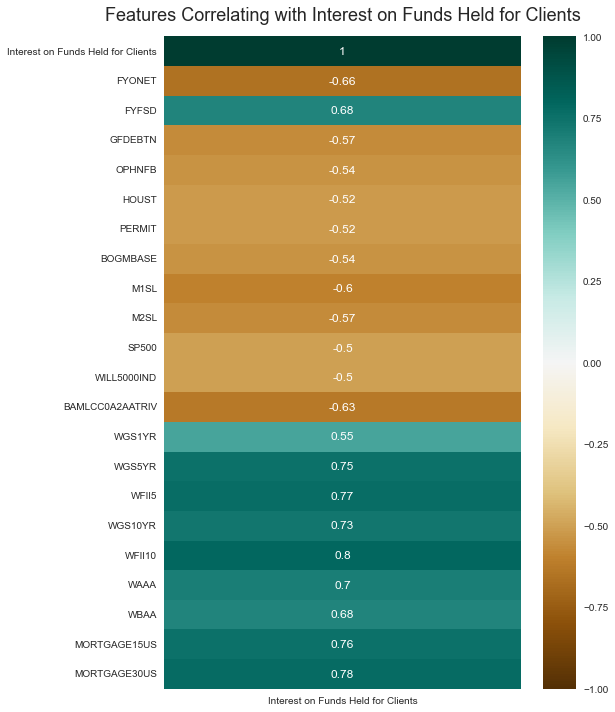

In [86]:
feature_cols = comb_df.columns.to_list()
feature_cols.remove('Calendar Date')
feature_cols.remove(target_col)

# Run Correlations to target
corr_df = comb_df.corr()[[target_col]]
corr_df = corr_df[corr_df[target_col].abs() >= correlation_threshold]

plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(corr_df, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with '+target_col, fontdict={'fontsize':18}, pad=16);

In [87]:
# Get a list of the features based on correlation
corr_df = corr_df.rename_axis('Feature').reset_index()
corr_feature_cols = corr_df['Feature'].tolist()
corr_feature_cols.remove(target_col)
#print(corr_feature_cols)

In [88]:
# run auto ml and get the most important features
best = models.run_auto_ml(train_df, test_df, target_col, feature_cols, False, ml_criteria)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,1436872.8236,4486157118129.0068,1597747.7147,-0.9053,0.6583,3.2640,0.0100
dt,Decision Tree Regressor,1609722.1667,5247264331117.3516,1757124.6800,-0.8890,0.6822,3.4540,0.0067
xgboost,Extreme Gradient Boosting,1691898.9167,5590372745216.0000,1870674.8333,-1.1990,0.7001,3.2817,0.0900
et,Extra Trees Regressor,1715583.5520,5285256425464.0879,1873827.1668,-1.4081,0.7113,3.4959,0.0567
rf,Random Forest Regressor,1747592.9200,5669397882866.8672,1916650.2439,-1.3936,0.7195,3.6992,0.0667
gbr,Gradient Boosting Regressor,1808705.1889,5840473284898.8584,1976230.3997,-1.7030,0.7301,3.5602,0.0200
ada,AdaBoost Regressor,1851356.9354,5981124169361.0283,2014279.4006,-1.8535,0.7363,3.4344,0.0300
dummy,Dummy Regressor,1883792.6250,5219946943829.3330,1984354.2917,-2.5630,0.7356,3.4363,0.0067
knn,K Neighbors Regressor,1913499.3125,6392133014869.3330,2087442.3750,-2.2254,0.7485,3.2617,0.0133
lightgbm,Light Gradient Boosting Machine,1924244.9981,5717645578951.4941,2054298.2152,-2.6089,0.7499,3.1493,0.0200


<class 'sklearn.linear_model._omp.OrthogonalMatchingPursuit'>


In [89]:
ml_features = models.get_important_features('xgboost', features_threshold)
ml_feature_cols = ml_features['Feature'].tolist()

# if len(ml_features.index) != 0:
#     # plot the most important features
#     fig = px.bar(ml_features.sort_values('Variable Importance', ascending=True),
#                  x='Variable Importance',
#                  y='Feature',
#                  orientation='h',
#                  title='Feature Importance Plot')
#     fig.show()

In [90]:
# ------------------------------------------------------------------------------------- #
# re-run the auto ml with only the important features
# ------------------------------------------------------------------------------------- #


# Here we need to figure out which set of features we want to use
# ml_features or corr_features
feature_cols = ml_feature_cols
#feature_cols = corr_feature_cols

feature_cols = ml_feature_cols
keeps = ['Calendar Date', target_col]+feature_cols
train_df = train_df[keeps]
test_df = test_df[keeps]
comb_df = comb_df[keeps]

best = models.run_auto_ml(train_df, test_df, target_col, feature_cols, False, ml_criteria)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,1387682.4372,4388077088540.7510,1526289.9257,-0.2442,0.6388,3.2557,0.0133
ridge,Ridge Regression,1414013.8333,4732952226474.6670,1607857.2708,-0.1373,0.6051,1.7591,0.0067
dt,Decision Tree Regressor,1542977.6111,5021849602254.0928,1699374.6649,-0.5639,0.6612,3.1376,0.0100
xgboost,Extreme Gradient Boosting,1644704.7500,5555198143146.6670,1804572.2083,-0.8344,0.6880,3.4265,0.1133
br,Bayesian Ridge,1670168.3114,6118427913754.6338,1855774.8953,-0.6513,0.6342,1.7837,0.0100
et,Extra Trees Regressor,1673289.0078,5275040171848.3535,1837623.4401,-1.1419,0.6982,3.3214,0.0600
rf,Random Forest Regressor,1681576.8863,5639547670761.8135,1862340.1446,-1.0629,0.7041,3.6146,0.0933
gbr,Gradient Boosting Regressor,1685381.4637,5636001505075.4287,1860588.3563,-1.0123,0.7005,3.4611,0.0200
llar,Lasso Least Angle Regression,1699770.0226,12119641059814.0684,2325715.3512,-0.6724,0.5876,1.6510,0.0067
lr,Linear Regression,1719554.3021,12685612100266.6660,2385463.6979,-0.8358,0.5859,1.5646,0.0100


<class 'sklearn.linear_model._omp.OrthogonalMatchingPursuit'>


In [110]:
dt_results = get_logs()

ValueError: No active run found. Check logging parameter in setup or to get logs for inactive run pass experiment_name.

ValueError: No active run found. Check logging parameter in setup or to get logs for inactive run pass experiment_name.

In [91]:
# ------------------------------------------------------------------------------------- #
# generate and plot predicted values on the original dataset
# ------------------------------------------------------------------------------------- #

predictions = predict_model(best, data=comb_df)
predictions['Date'] = pd.date_range(start=str(train_start_dt), end = str(test_end_dt), freq = 'MS')
predictions.rename(columns={'Label':target_col+' - ML Predicted'}, inplace=True)
fig = px.line(predictions, x='Date', y=[target_col, target_col+' - ML Predicted'], template = 'plotly_white')
fig.show()

# ------------------------------------------------------------------------------------- #
# This section now applies the trained/tested model to make future predictions
# ------------------------------------------------------------------------------------- #

In [92]:
act_df = all_df[all_df['Calendar Date'].astype(int) >= int(pred_start_dt)]
act_df = act_df[['Calendar Date', target_col]]
act_df['Calendar Date'] = pd.to_datetime(act_df['Calendar Date'])

In [93]:
# create the future predictions dataframe
if has_actuals:
    pred_df = models.run_auto_arima(comb_df, feature_cols, pred_start_dt, forecast_window, ci=False)
    final_best = finalize_model(best)
    #future_dates = pd.date_range(start = pred_start_dt, end = pred_end_dt, freq = 'MS')
    pred_df = predict_model(final_best, data=pred_df)
    #pred_df = pred_df[['Calendar Date', 'Label']]
    pred_df = pred_df.rename(columns={'Label':ml_col})[['Calendar Date', ml_col]]
    concat_df = pd.merge(act_df, pred_df ,on='Calendar Date', how='inner')
    
    # get plan data
    plan_df = dl.get_clean_data(train_start_dt, pred_end_dt, file_path, type='plan')
    plan_df = plan_df[['Calendar Date', target_col]]
    plan_df.rename(columns={target_col:plan_col}, inplace=True)
    plan_df['Calendar Date'] = pd.to_datetime(plan_df['Calendar Date'])
    concat_df = pd.merge(concat_df,plan_df, on='Calendar Date', how='inner')
    
    # get forecast data
    fcst_df = dl.get_clean_data(train_start_dt, pred_end_dt, file_path,
                                type='forecast',
                                forecast_type=forecast_type)
    fcst_df = fcst_df[['Calendar Date', target_col]]
    fcst_df.rename(columns={target_col:fcst_col}, inplace=True)
    fcst_df['Calendar Date'] = pd.to_datetime(fcst_df['Calendar Date'])
    concat_df = pd.merge(concat_df,fcst_df, on='Calendar Date', how='inner')

############################  Running Auto ARIMA for M1SL   ############################
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.48 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1275.324, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=inf, Time=0.29 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1236.659, Time=0.07 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1237.038, Time=0.40 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1237.019, Time=0.29 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=1238.975, Time=1.26 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1238.315, Time=0.27 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=inf, Time=0.40 sec
 ARIMA(0,1,0)(1,1,0)[12] intercept   : AIC=1237.581, Time=0.36 sec

Best model:  ARIMA(0,1,0)(1,1,0)[12]          
Total fit time: 4.212 seconds
###########

In [94]:
# run UTS
uts_df = comb_df[['Calendar Date', target_col]]
uts_df = models.run_auto_arima(uts_df, [target_col], pred_start_dt, forecast_window, ci=True)
uts_df.rename(columns={target_col:uts_col}, inplace=True)

############################  Running Auto ARIMA for Interest on Funds Held for Clients   ############################
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=2258.343, Time=0.15 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2294.497, Time=0.00 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2262.118, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2256.611, Time=0.08 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2280.180, Time=0.02 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2256.875, Time=0.12 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2256.715, Time=0.20 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2257.195, Time=0.05 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2258.715, Time=0.50 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=2284.385, Time=0.04 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=2261.030, Time=0.11 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=2261.170, Time=0.05 sec
 ARIMA(1,1,2)(0,1,1)[12]          

In [95]:
concat_df = pd.merge(concat_df,uts_df, on='Calendar Date', how='inner')

In [96]:
# combine all data together
concat_df = pd.concat([comb_df[['Calendar Date', target_col]],concat_df], axis=0)

In [107]:
# show plot
fig = px.line(concat_df, x='Calendar Date', y=[target_col, ml_col, uts_col, plan_col, fcst_col], template='plotly_white')
fig.show()

In [108]:
concat_df[concat_df['Calendar Date'] >= pred_start_dt]

,Calendar Date,Interest on Funds Held for Clients,Interest on Funds Held for Clients - ML Predicted,Interest on Funds Held for Clients - Plan,Interest on Funds Held for Clients - 2+10 Forecast,Interest on Funds Held for Clients - UTS Predicted,Interest on Funds Held for Clients_lower_ci,Interest on Funds Held for Clients_upper_ci
0,2021-06-01,-451367.0,8.838785e+06,4687137.0,-451367.0,-2.347883e+06,-6.770667e+06,2.074901e+06
1,2021-07-01,-386211.0,8.533176e+06,4727006.0,-386211.0,-2.033447e+06,-6.937266e+06,2.870372e+06
2,2021-08-01,-398389.0,8.225735e+06,5402709.0,4648749.0,-2.398601e+06,-7.740311e+06,2.943108e+06
3,2021-09-01,-517688.0,8.291251e+06,4636944.0,4637734.0,-2.446004e+06,-8.192332e+06,3.300325e+06
4,2021-10-01,-414842.0,8.413610e+06,4684411.0,4686972.0,-2.314003e+06,-8.438276e+06,3.810269e+06
5,2021-11-01,-462587.0,8.583186e+06,5397348.0,4644354.0,-2.502411e+06,-8.982622e+06,3.977800e+06
6,2021-12-01,-325405.0,8.568823e+06,4840579.0,4846830.0,-1.748759e+06,-8.566351e+06,5.068833e+06
7,2022-01-01,-311881.0,8.383558e+06,4756334.0,4760590.0,-1.905915e+06,-9.044961e+06,5.233132e+06


In [98]:
predictions_path = proyect_path+"/data/predictions/"+model_run_date
if not os.path.exists(predictions_path):
    os.makedirs(predictions_path)
    print("Directory created")

Directory created


In [210]:
df_write = concat_df.rename(columns={target_col: 'Actual',
                           ml_col: 'ML Predicted',
                           uts_col: 'UTS Predicted',
                           plan_col: 'Plan',
                           fcst_col:' Forecast'})

In [76]:
df_write['Item'] = target_col

In [77]:
df_write

,Calendar Date,Actual,ML Predicted,Plan,Forecast,UTS Predicted,Item
0,2014-06-01,2.074346e+08,NaN,NaN,NaN,NaN,Total Revenue
1,2014-07-01,2.483619e+08,NaN,NaN,NaN,NaN,Total Revenue
2,2014-08-01,2.110434e+08,NaN,NaN,NaN,NaN,Total Revenue
3,2014-09-01,2.064182e+08,NaN,NaN,NaN,NaN,Total Revenue
4,2014-10-01,2.584593e+08,NaN,NaN,NaN,NaN,Total Revenue
...,...,...,...,...,...,...,...
3,2021-09-01,3.709236e+08,3.331832e+08,3.567864e+08,6.990509e+08,3.560265e+08,Total Revenue
4,2021-10-01,3.574400e+08,3.399423e+08,3.410163e+08,6.567897e+08,3.609818e+08,Total Revenue
5,2021-11-01,3.646379e+08,3.448046e+08,3.480824e+08,6.753844e+08,3.510391e+08,Total Revenue
6,2021-12-01,4.078692e+08,3.495820e+08,3.752561e+08,7.258485e+08,3.833378e+08,Total Revenue


In [78]:
df_write.to_parquet(predictions_path+"/"+target_col.replace(" ","")+".parquet")

In [99]:
# compute mape_df
mape_df = concat_df[['Calendar Date', target_col, ml_col, uts_col, plan_col, fcst_col]]
mape_df = mape_df[mape_df['Calendar Date'] >= datetime.strptime(pred_start_dt, '%Y%m%d')]
mape_df = models.compute_apes_and_mapes(mape_df, 'Calendar Date', target_col, fcst_cols)
mape_df.rename(index={True:'MAPE'}, inplace=True)
#print(mape_df)


In [100]:
mape_df = pd.concat([mape_df.reset_index(drop=True), uts_df], axis=1)

In [101]:
mape_df

,Calendar Date,Interest on Funds Held for Clients,Interest on Funds Held for Clients - Plan,Interest on Funds Held for Clients - Plan - APE,Interest on Funds Held for Clients - 2+10 Forecast,Interest on Funds Held for Clients - 2+10 Forecast - APE,Interest on Funds Held for Clients - ML Predicted,Interest on Funds Held for Clients - ML Predicted - APE,Interest on Funds Held for Clients - UTS Predicted,Interest on Funds Held for Clients - UTS Predicted - APE,Calendar Date,Interest on Funds Held for Clients - UTS Predicted,Interest on Funds Held for Clients_lower_ci,Interest on Funds Held for Clients_upper_ci
0,2021-06-01 00:00:00,-451367.0,4687137.0,-11.384315,-451367.0,-0.000000,8.838785e+06,-20.582257,-2.347883e+06,-4.201716,2021-06-01,-2.347883e+06,-6.770667e+06,2.074901e+06
1,2021-07-01 00:00:00,-386211.0,4727006.0,-13.239439,-386211.0,-0.000000,8.533176e+06,-23.094595,-2.033447e+06,-4.265120,2021-07-01,-2.033447e+06,-6.937266e+06,2.870372e+06
2,2021-08-01 00:00:00,-398389.0,5402709.0,-14.561391,4648749.0,-12.668869,8.225735e+06,-21.647496,-2.398601e+06,-5.020752,2021-08-01,-2.398601e+06,-7.740311e+06,2.943108e+06
3,2021-09-01 00:00:00,-517688.0,4636944.0,-9.957024,4637734.0,-9.958550,8.291251e+06,-17.015923,-2.446004e+06,-3.724861,2021-09-01,-2.446004e+06,-8.192332e+06,3.300325e+06
4,2021-10-01 00:00:00,-414842.0,4684411.0,-12.292036,4686972.0,-12.298210,8.413610e+06,-21.281480,-2.314003e+06,-4.578035,2021-10-01,-2.314003e+06,-8.438276e+06,3.810269e+06
5,2021-11-01 00:00:00,-462587.0,5397348.0,-12.667747,4644354.0,-11.039958,8.583186e+06,-19.554750,-2.502411e+06,-4.409600,2021-11-01,-2.502411e+06,-8.982622e+06,3.977800e+06
6,2021-12-01 00:00:00,-325405.0,4840579.0,-15.875552,4846830.0,-15.894762,8.568823e+06,-27.332795,-1.748759e+06,-4.374099,2021-12-01,-1.748759e+06,-8.566351e+06,5.068833e+06
7,2022-01-01 00:00:00,-311881.0,4756334.0,-16.250477,4760590.0,-16.264123,8.383558e+06,-27.880631,-1.905915e+06,-5.111032,2022-01-01,-1.905915e+06,-9.044961e+06,5.233132e+06
8,NaN,NaN,NaN,-13.278498,NaN,-9.765559,NaN,-22.298741,NaN,-4.460652,NaT,NaN,NaN,NaN


In [112]:
from openpyxl import Workbook

In [142]:
metadata_path = proyect_path + "/data/metadata/"
mapes_file = metadata_path + model_run_date + "_mape.xlsx"

In [146]:
os.path.exists(mapes_file)

True

In [147]:
if os.path.exists(mapes_file):
    book = load_workbook(mapes_file)
else:
    book = Workbook()

In [148]:
#mapes_file = proyect_path + './mapes.xlsx'
#mape_df.to_excel(mapes_file, sheet_name=target_col[0:31])
#book = load_workbook(mapes_file)
with pd.ExcelWriter(mapes_file, engine = 'openpyxl') as writer:
    writer.book = book
    mape_df.to_excel(writer, sheet_name = target_col[0:30], index=False)
    #book.save(mapes_file)

In [141]:
writer.close()

In [22]:
ml_col

'Payroll blended products - ML Predicted'

In [153]:
df = pd.read_parquet("C:/Users/bruno.gonzalez/DataspellProjects/Paychex_revenue_forecast/data/predictions/20220509")

In [154]:
df

,Calendar Date,Item,Actual,ML Predicted,UTS Predicted,Plan,Forecast,Lower CI,Upper CI
0,2021-06-01,Payroll blended products,1.142380e+08,1.069185e+08,1.145630e+08,1.134306e+08,1.142380e+08,9.281367e+07,1.363124e+08
1,2021-07-01,Payroll blended products,1.131859e+08,1.110458e+08,1.157635e+08,1.143207e+08,1.131859e+08,9.176588e+07,1.397611e+08
2,2021-08-01,Payroll blended products,1.157689e+08,1.060490e+08,1.135166e+08,1.167989e+08,1.182797e+08,8.548083e+07,1.415523e+08
3,2021-09-01,Payroll blended products,1.164069e+08,1.087553e+08,1.153946e+08,1.126937e+08,1.132994e+08,8.442522e+07,1.463641e+08
4,2021-10-01,Payroll blended products,1.074553e+08,1.026939e+08,1.174904e+08,1.045306e+08,1.053015e+08,8.370521e+07,1.512755e+08
5,2021-11-01,Payroll blended products,1.175037e+08,1.053842e+08,1.143671e+08,1.132584e+08,1.141515e+08,7.800990e+07,1.507242e+08
6,2021-12-01,Payroll blended products,1.278009e+08,1.143640e+08,1.278934e+08,1.195799e+08,1.199513e+08,8.913152e+07,1.666554e+08
7,2022-01-01,Payroll blended products,1.038698e+08,1.069483e+08,1.105324e+08,1.026955e+08,1.036316e+08,6.950595e+07,1.515589e+08
8,2021-06-01,W-2 Revenue,1.456643e+05,1.787953e+07,8.334384e+04,9.433619e+04,1.456643e+05,-2.347631e+07,2.364300e+07
9,2021-07-01,W-2 Revenue,1.295130e+05,1.787953e+07,1.423647e+05,1.629054e+05,1.295130e+05,-2.343360e+07,2.371833e+07
